_Lambda School Data Science - Model Validation_

## Example solution to the Cross-Validation assignment — plus Feature Selection!

See also Sebastian Raschka's example, [Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb).

In [0]:
#!pip install tsfresh
#!pip install seaborn --upgrade

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_colwidth', 0)

### Here in we pull in all our feature creation functions (from Jake Vanderplas and a few from our cohort)

In [0]:
# We'll modify a project from Python Data Science Handbook by Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic
    
# Predicting Bicycle Traffic

# As an example, let's take a look at whether we can predict the number of 
# bicycle trips across Seattle's Fremont Bridge based on weather, season, 
# and other factors.

# We will join the bike data with another dataset, and try to determine the 
# extent to which weather and seasonal factors—temperature, precipitation, 
# and daylight hours—affect the volume of bicycle traffic through this corridor. 
# Fortunately, the NOAA makes available their daily weather station data 
# (I used station ID USW00024233) and we can easily use Pandas to join 
# the two data sources.


import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyRegressor
from datetime import datetime
from datetime import date


def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
  
  
    daily.insert(0, 'ID', range(0, len(daily)))

    return daily

  
def ordinal(daily):
    daily = daily.copy()
    # Add a column of the dates
    daily['date_'] = daily.index
    
    # Date stuff https://docs.python.org/3/library/datetime.html#datetime.date.fromisoformat
    # Add some day context
    daily.insert(0, 'weekday_', daily.date_.apply(lambda x: x.weekday()))
    daily.insert(0, 'dayOfMonth_',  daily.date_.apply(lambda x: x.day))
    daily.insert(0, 'month_',  daily.date_.apply(lambda x: x.month))
    daily.insert(0, 'year_',  daily.date_.apply(lambda x: x.year))  
    
    # Drop date column
    daily = daily.drop(columns='date_')
    
    return daily
  
    
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    
    return X_train, X_test, y_train, y_test

  
  
def one_hot_encoded(X):
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    return X

  

def jake_wrangle(X):  
    X = X.copy()

    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

  

def wrangle(X):
    # From Daniel H (DS1 KotH)
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    X['PRCP_yest'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_ln'] = X['TMIN'] **2
    
    return X

 

In [0]:
# Download and join data into a dataframe
data = load()

In [5]:
data.head()

,ID,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-10-04,0,3475.0,0,0,0,189,83,65,3521.0
2012-10-05,1,3148.0,0,0,0,217,89,57,3475.0
2012-10-06,2,2006.0,0,0,0,239,78,51,3148.0
2012-10-07,3,2142.0,0,0,0,239,78,13,2006.0
2012-10-08,4,3537.0,0,0,0,211,78,19,2142.0


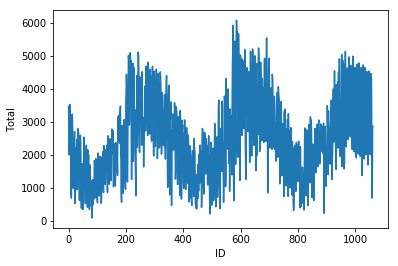

In [6]:
import seaborn as sns
sns.lineplot(data.ID, data.Total)

### This is an example of a pipeline + parameter grid. 

Remember: If your dataset is massive, be sure to take a random subset sample to try fitting with the training data to start getting scores. 

### Benchmark / Baseline using Dummy Regressor in Pipe

In [7]:
%%time
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    DummyRegressor(strategy='mean'))

pipe.fit(X_train, y_train)

### Get the scores with the MAE Function
## Predict with X_test features and Compare predictions to y_test labels
y_pred = pipe.predict(X_train)
dummy_train_score = mean_absolute_error(y_train, y_pred)
print('Dummy Regression Train Score:', dummy_train_score)


## Predict with X_test features and Compare predictions to y_test labels
y_pred = pipe.predict(X_test)
dummy_test_score = mean_absolute_error(y_test, y_pred)
print('Dummy Regression Test Score:', dummy_test_score)


Dummy Regression Train Score: 980.8981106765484
Dummy Regression Test Score: 1341.2051609553478
CPU times: user 14.9 ms, sys: 13 ms, total: 27.9 ms
Wall time: 14 ms


In [8]:
%%time

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
RidgeBaseline_train_score = gs.score(X_train, y_train)
print('RidgeBaseline Train Score:', -RidgeBaseline_train_score)

RidgeBaseline_test_score = gs.score(X_test, y_test)
print('RidgeBaseline Test Score:', -RidgeBaseline_test_score)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 604.6453429336518

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=4, score_func=<function f_regression at 0x7fdfdaae0c80>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

RidgeBaseline Train Score: 601.7510401226398
RidgeBaseline Test Score: 773.107268536548
CPU times: user 784 ms, sys: 7.95 ms, total: 792 ms
Wall time: 816 ms


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.8s finished


###  Apply data `ordinal`

In [9]:
%%time
ordinal_data = ordinal(data)

# Split data into train and test
X_train, X_test, y_train, y_test = split(ordinal_data)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
ord_train_score = gs.score(X_train, y_train)
print('Ordinal Train Score:', -ord_train_score)

ord_test_score = gs.score(X_test, y_test)
print('Ordinal Test Score:', -ord_test_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits

Cross-Validation Score: 389.2116166662251

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=5, score_func=<function f_regression at 0x7fdfdaae0c80>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Ordinal Train Score: 385.55035508465824
Ordinal Test Score: 448.71439473552834
CPU times: user 1.24 s, sys: 16 ms, total: 1.26 s
Wall time: 1.25 s


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    1.2s finished


### Apply `one_hot_encoded` (classmates function)

In [10]:
#%%time
one_hot_data = one_hot_encoded(data)

# Split data into train and test
X_train, X_test, y_train, y_test = split(one_hot_data)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
oh_train_score = gs.score(X_train, y_train)
print('Train Score:', -oh_train_score)

oh_test_score = gs.score(X_test, y_test)
print('Test Score:', -oh_test_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 84 candidates, totalling 252 fits

Cross-Validation Score: 317.0056086250159

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=24, score_func=<function f_regression at 0x7fdfdaae0c80>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Train Score: 290.9695287750331
Test Score: 625.7986098051067


[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:    4.4s finished


In [11]:
print('Ordinal Train Score:', -ord_train_score)
print('Ordinal Test Score:', -ord_test_score)
print('\n')
print('One-Hot Train Score:', -oh_train_score)
print('One-Hot Test Score:', -oh_test_score)

Ordinal Train Score: 385.55035508465824
Ordinal Test Score: 448.71439473552834


One-Hot Train Score: 290.9695287750331
One-Hot Test Score: 625.7986098051067


###  Just feature Wrangling

In [42]:
%%time
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test = wrangle(X_test)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
RRtrain_score = gs.score(X_train, y_train)
print('Just Wrangling Train Score:', -RRtrain_score)

RRtest_score = gs.score(X_test, y_test)
print('Just Wrangling Test Score:', -RRtest_score)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 595.6496902158523

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=15, score_func=<function f_regression at 0x7fdfdaae0c80>)), ('ridge', Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Just Wrangling Train Score: 590.9809401021859
Just Wrangling Test Score: 770.2808314805894
CPU times: user 2.51 s, sys: 1.46 s, total: 3.97 s
Wall time: 2.05 s


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:    2.0s finished


### Comparing 3 seperate runs. 

In [0]:
# Comparing 1 set of variables for each
# This is how I did it at first.

print('Dummy Regression Train Score:', dummy_train_score)
print('Dummy Regression Test Score:', dummy_test_score)
print('\n')
print('RidgeBaseline Train Score:', -RidgeBaseline_train_score)
print('RidgeBaseline Test Score:', -RidgeBaseline_test_score)
print('\n')


print('Just Ordinal Train Score:', -ord_train_score)
print('Just Ordinal Test Score:', -ord_test_score)
print('\n')

print('Just One-Hot Train Score:', -oh_train_score)
print('Just One-Hot Test Score:', -oh_test_score)
print('\n')

print('Just Wrangling Train Score:', -RRtrain_score)
print('Just Wrangling Test Score:', -RRtest_score)


## I'm going to rewrite this here

In [0]:
# Rewriting my Dummy Regression Baseline one as a function
def baseline(data):
    name = "Dummy Regression Baseline"
    # Split data into train and test
    X_train, X_test, y_train, y_test = split(data)

    # Define an estimator and param_grid
    # WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
    pipe = make_pipeline(
        RobustScaler(), 
        DummyRegressor(strategy='mean'))
    pipe.fit(X_train, y_train)

    scorer = 'MAE'

    ### Get the scores with the MAE Function
    y_pred_train = pipe.predict(X_train)  
    y_pred_test = pipe.predict(X_test)

    train_score = mean_absolute_error(y_train, y_pred_train)
    test_score = mean_absolute_error(y_test, y_pred_test)
    score_variance = test_score - train_score
    cv_score = 0.0000000000000
    best_params = pipe.get_params
    best_estimator = ""
    selected_names = list(X_train.columns)
    unselected_names = []

    return [name, scorer, train_score, test_score, score_variance, cv_score, selected_names, unselected_names, best_params, best_estimator]


# Rewriting my GridSearch CV as a function 
def compare(data, name):
    X_train, X_test, y_train, y_test = split(data)

    pipe = make_pipeline(
        RobustScaler(), 
        SelectKBest(f_regression), 
        Ridge())

    param_grid = {
        'selectkbest__k': range(1, len(X_train.columns)+1), 
        'ridge__alpha': [0.1, 1.0, 10.]
    }

    scorer = 'MAE'

    # Fit on the train set, with grid search cross-validation
    gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                      scoring='neg_mean_absolute_error', 
                      verbose=0)
    gs.fit(X_train, y_train)

    train_score = -gs.score(X_train, y_train)
    test_score = -gs.score(X_test, y_test)
    score_variance = test_score - train_score
    cv_score = -gs.best_score_
    best_params = gs.best_params_
    best_estimator = gs.best_estimator_

    # selected features? 
    # 'selectkbest' is the autogenerated name of the SelectKBest() function in the pipeline
    selector = gs.best_estimator_.named_steps['selectkbest']
    all_names = X_train.columns

    # get_support returns a mask of the columns in True / False
    selected_mask = selector.get_support()
    # Passing the boolean list as the column names creates a masked list.  
    selected_names = list(all_names[selected_mask])
    unselected_names = list(all_names[~selected_mask])

    return [name, scorer, train_score, test_score, score_variance, cv_score, selected_names, unselected_names, best_params, best_estimator]

In [60]:
# Going to call it now( )
%%time
variables = ["name","scorer","train_score","test_score","score_variance","cv_score","selected_features","unselected_features","best_params","best_estimator"]
gridCompare = []

# Call the Baseline function
baseliner = baseline(data)
gridCompare.append(baseliner)

# Prep the Data for each Compare Scenario
Z_data = data
A_data = ordinal(data)
B_data = one_hot_encoded(data)
C_data = one_hot_encoded(A_data)
D_data = wrangle(A_data)
E_data = wrangle(B_data)
F_data = wrangle(C_data)

# Call the Compare function for the other scenarios. 
dataz = [Z_data, A_data, B_data, C_data, D_data, E_data, F_data]
names = ["Ridge Baseline",'Just Ordinal','Just One Hot','Ord + One Hot','Wrangled + Ordinal','Wrangled + OH','All Combined']
for i, j in zip(dataz, names): gridCompare.append(compare(i,j))
gridComp = pd.DataFrame(gridCompare, columns = variables)

CPU times: user 35.5 s, sys: 21.5 s, total: 57 s
Wall time: 30 s


In [61]:
gridComp.T.head(8)

,0,1,2,3,4,5,6,7
name,Test,Ridge Baseline,Just Ordinal,Just One Hot,Ord + One Hot,Wrangled + Ordinal,Wrangled + OH,All Combined
scorer,MAE,MAE,MAE,MAE,MAE,MAE,MAE,MAE
train_score,601.751,601.751,385.55,290.97,290.953,362.645,272.788,272.833
test_score,773.107,773.107,448.714,625.799,635.768,414.397,335.934,333.885
cv_score,604.645,604.645,389.212,317.006,316.724,375.381,297.196,297.141
selected_names,"[PRCP, TMAX, TMIN, Total_yesterday]","[PRCP, TMAX, TMIN, Total_yesterday]","[weekday_, PRCP, TMAX, TMIN, Total_yesterday]","[ID, PRCP, SNWD, TMAX, TMIN, AWND, Total_yesterday, Mon, Tue, Wed, Thu, Sat, Sun, holiday, Jan, Feb, Mar, May, Jun, Jul, Aug, Sep, Nov, Dec]","[year_, weekday_, ID, PRCP, TMAX, TMIN, AWND, Total_yesterday, Mon, Tue, Wed, Thu, Sat, Sun, holiday, Jan, Feb, Mar, May, Jun, Jul, Aug, Nov, Dec]","[weekday_, ID, PRCP, TMAX, TMIN, AWND, Total_yesterday, daylight_hrs, Temp (C), dry day, annual, PRCP_yest, Windchill, Rl_Cold, TMIN_ln]","[ID, PRCP, TMAX, TMIN, AWND, Total_yesterday, Mon, Tue, Wed, Thu, Sat, Sun, holiday, Jan, Feb, Mar, May, Jun, Jul, Aug, Sep, Nov, Dec, daylight_hrs, Temp (C), dry day, annual, PRCP_yest, Windchill, Rl_Cold, TMIN_ln]","[year_, weekday_, ID, PRCP, TMAX, TMIN, AWND, Total_yesterday, Mon, Tue, Wed, Thu, Sat, Sun, holiday, Jan, Feb, Mar, May, Jun, Jul, Aug, Nov, Dec, daylight_hrs, Temp (C), dry day, annual, PRCP_yest, Windchill, Rl_Cold, TMIN_ln]"
unselected_names,"[ID, SNOW, SNWD, AWND]","[ID, SNOW, SNWD, AWND]","[year_, month_, dayOfMonth_, ID, SNOW, SNWD, AWND]","[SNOW, Fri, Apr, Oct]","[month_, dayOfMonth_, SNOW, SNWD, Fri, Apr, Sep, Oct]","[year_, month_, dayOfMonth_, SNOW, SNWD]","[SNOW, SNWD, Fri, Apr, Oct]","[month_, dayOfMonth_, SNOW, SNWD, Fri, Apr, Sep, Oct]"
best_params,"{'ridge__alpha': 1.0, 'selectkbest__k': 4}","{'ridge__alpha': 1.0, 'selectkbest__k': 4}","{'ridge__alpha': 1.0, 'selectkbest__k': 5}","{'ridge__alpha': 1.0, 'selectkbest__k': 24}","{'ridge__alpha': 1.0, 'selectkbest__k': 24}","{'ridge__alpha': 1.0, 'selectkbest__k': 15}","{'ridge__alpha': 1.0, 'selectkbest__k': 31}","{'ridge__alpha': 1.0, 'selectkbest__k': 32}"


In [24]:
# Here I'm going to compare my dummy regression baseline to all of my other
# feature engineered 
# Comparing 1 set of variables for each
print("Some Comparisons")

print('Dummy Regression Train Score:', dummy_train_score)
print('Dummy Regression Test Score:', dummy_test_score)
print('\n')






'''###
names = "Ridge Baseline"
Z_data = data
compare(Z_data, name)

### 
name = 'Just Ordinal'
A_data = ordinal(data)
compare(A_data, name)

### 
name = 'Just One Hot'
B_data = one_hot_encoded(data)
compare(B_data, name)

### 
name = 'Ord + One Hot'
C_data = one_hot_encoded(A_data)
compare(C_data, name)

### 
name = 'Wrangled + Ordinal'
D_data = wrangle(A_data)
compare(D_data, name)

### 
name = 'Wrangled + OH'
E_data = wrangle(B_data)
compare(E_data, name)

### 
name = 'All Combined'
F_data = wrangle(C_data)
compare(F_data, name)
'''

Some Comparisons
Dummy Regression Train Score: 980.8981106765484
Dummy Regression Test Score: 1341.2051609553478



Ridge Baseline Cross-Validation Score: 604.6453429336518
Ridge Baseline Train Score:            601.7510401226398
Ridge Baseline Test Score:             773.107268536548


Just Ordinal Cross-Validation Score: 389.2116166662251
Just Ordinal Train Score:            385.55035508465824
Just Ordinal Test Score:             448.71439473552834


Just One Hot Cross-Validation Score: 317.0056086250159
Just One Hot Train Score:            290.9695287750331
Just One Hot Test Score:             625.7986098051067


Ord + One Hot Cross-Validation Score: 316.7241668646224
Ord + One Hot Train Score:            290.95264043258334
Ord + One Hot Test Score:             635.7680843548015


Wrangled + Ordinal Cross-Validation Score: 375.38130158393705
Wrangled + Ordinal Train Score:            362.64459025651087
Wrangled + Ordinal Test Score:             414.397277738424


Wrangled + OH Cross

### Combine all 3 feature engineering sets. 

In [13]:
%%time
ordinal_data = ordinal(data)
ord_oh_data = one_hot_encoded(ordinal_data)
wrangled_oh_ord_data = wrangle(ord_oh_data)

# Split data into train and test
X_train, X_test, y_train, y_test = split(wrangled_oh_ord_data)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
fe_train_score = gs.score(X_train, y_train)
print('Feature Engineered Train Score:', -fe_train_score)

fe_test_score = gs.score(X_test, y_test)
print('Feature Engineered Test Score:', -fe_test_score)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 297.1413242158009

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=32, score_func=<function f_regression at 0x7f212e69fd90>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Feature Engineered Train Score: 272.8330918063642
Feature Engineered Test Score: 333.8853138194594
CPU times: user 10.3 s, sys: 7.18 s, total: 17.5 s
Wall time: 8.85 s


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    8.6s finished


In [15]:
%%time
ordinal_data = ordinal(data)
ord_oh_data = one_hot_encoded(ordinal_data)
wrangled_oh_ord_data = wrangle(ord_oh_data)

# Split data into train and test
X_train, X_test, y_train, y_test = split(wrangled_oh_ord_data)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
fe_train_score = gs.score(X_train, y_train)
print('Feature Engineered Train Score:', -fe_train_score)

fe_test_score = gs.score(X_test, y_test)
print('Feature Engineered Test Score:', -fe_test_score)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 297.1413242158009

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=32, score_func=<function f_regression at 0x7f212e69fd90>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Feature Engineered Train Score: 272.8330918063642
Feature Engineered Test Score: 333.8853138194594
CPU times: user 10.2 s, sys: 7.19 s, total: 17.4 s
Wall time: 8.82 s


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    8.6s finished


### Notes on Pipeline / GridScore

#### Then we can get the final test score (using MAE function)

Using gs.predict calls all the grid score fit/transforms and applies them to our X_test data in this case. 

Then we can calculate our score useing those test predictions. 

In [16]:
# Predict with X_test features
y_pred = gs.predict(X_test)

# Compare predictions to y_test labels
test_score = mean_absolute_error(y_test, y_pred)
print('Test Score:', test_score)

Test Score: 333.8853138194594


#### Or use the GridSearch's `score` method to get the final test score. 

This method just generates the test predictions and scores them, returning the (negative) test score to you. So you apply the negative symbol to flip the sign from negative to positive. 

In [17]:
train_score = gs.score(X_train, y_train)
print('Train Score:', -train_score)

# Or use the grid search's score method, 
# which combines these steps
test_score = gs.score(X_test, y_test)

print('Test Score:', -test_score)

Train Score: 272.8330918063642
Test Score: 333.8853138194594


In [0]:
'''def vary_scale(typ): 
  if typ=='robust': return RobustScaler
  elif typ=='standard': return StandardScaler
  else: Fail

pipe = Pipeline(steps=[  ... , ('scale', FunctionTransformer(vary_scale)), ... ])

param_grid = { 
    ... , 
    FunctionTransformer'vary_scale__choice': ['robust', 'standard'],
    ... }

search = GridSearchCV(pipe, param_grid, ...)''';

### Now we can explore and see what features we actually ended up selecting. 

In [19]:
# Which features were selected?
# 'selectkbest' is the autogenerated name of the SelectKBest() function in the pipeline
selector = gs.best_estimator_.named_steps['selectkbest']
all_names = X_train.columns

# get_support returns a mask of the columns in True / False
selected_mask = selector.get_support()
# Passing the boolean list as the column names creates a 
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print()
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
year_
weekday_
ID
PRCP
TMAX
TMIN
AWND
Total_yesterday
Mon
Tue
Wed
Thu
Sat
Sun
holiday
Jan
Feb
Mar
May
Jun
Jul
Aug
Nov
Dec
daylight_hrs
Temp (C)
dry day
annual
PRCP_yest
Windchill
Rl_Cold
TMIN_ln

Features not selected:
month_
dayOfMonth_
SNOW
SNWD
Fri
Apr
Sep
Oct


In [20]:
from sklearn.preprocessing import PolynomialFeatures

#%%time
ordinal_data = ordinal(data)
ord_oh_data = one_hot_encoded(ordinal_data)
wrangled_oh_ord_data = wrangle(ord_oh_data)

# Split data into train and test
X_train, X_test, y_train, y_test = split(wrangled_oh_ord_data)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    PolynomialFeatures(degree=2),
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
fe_train_score = gs.score(X_train, y_train)
print('Feature Engineered Train Score:', -fe_train_score)

fe_test_score = gs.score(X_test, y_test)
print('Feature Engineered Test Score:', -fe_test_score)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 337.3047538164374

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('selectkbest', SelectKBest(k=36, score_func=<function f_regression at 0x7f212e69fd90>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Feature Engineered Train Score: 276.24247184972216
Feature Engineered Test Score: 395.80984993785677


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   30.1s finished


In [21]:
print('Feature Engineered Train Score:', -fe_train_score)
print('Feature Engineered Test Score:', -fe_test_score)

Feature Engineered Train Score: 276.24247184972216
Feature Engineered Test Score: 395.80984993785677


#### An unecessary attempt with Tsfresh (Relevant Time Feature Augmentor)

In [0]:
'''# Find all the features, even the irrelevant ones.
%%time
from tsfresh.transformers import RelevantFeatureAugmenter
from tsfresh import extract_features

extracted_features = extract_features(wrangled_oh_ord_data, column_id="order", column_sort="ID")

from tsfresh.utilities.dataframe_functions import impute

features = impute(extracted_features)''';

In [23]:
X_train.shape

(963, 40)

## BONUS: Recursive Feature Elimination!

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

In [24]:
from sklearn.feature_selection import RFECV

X_train_scaled = RobustScaler().fit_transform(X_train)
rfe = RFECV(Ridge(alpha=1.0), scoring='neg_mean_absolute_error', cv=3)
X_train_subset = rfe.fit_transform(X_train_scaled, y_train)

all_names = X_train.columns
selected_mask = rfe.support_
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print()
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
dayOfMonth_
weekday_
PRCP
TMAX
TMIN
AWND
Total_yesterday
Mon
Tue
Wed
Thu
Fri
Sat
Sun
holiday
Feb
Mar
Apr
May
Jun
Oct
Dec
daylight_hrs
Temp (C)
dry day
Windchill
Rl_Cold
TMIN_ln

Features not selected:
year_
month_
ID
SNOW
SNWD
Jan
Jul
Aug
Sep
Nov
annual
PRCP_yest


In [0]:
X_train_subset = pd.DataFrame(X_train_subset, columns=selected_names)

In [0]:
X_test_subset = rfe.transform(X_test)
X_test_subset = pd.DataFrame(X_test_subset, columns=selected_names)

In [27]:
print(X_train.shape, X_train_subset.shape, X_test.shape, X_test_subset.shape)

(963, 40) (963, 28) (100, 40) (100, 28)


# RFE again, but with polynomial features and interaction terms!

### Apply a Polynomial Transformation

In [28]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_polynomial = poly.fit_transform(X_train)

print(X_train.shape, X_train_polynomial.shape)

(963, 40) (963, 861)


### Apply a Scaler & RFECV

In [29]:
%%time
from sklearn.feature_selection import RFECV

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_polynomial)

rfe = RFECV(Ridge(alpha=1.0), scoring='neg_mean_absolute_error', 
            step=10, cv=3, verbose=0)

X_train_subset = rfe.fit_transform(X_train_scaled, y_train)

CPU times: user 13.7 s, sys: 10.6 s, total: 24.3 s
Wall time: 12.3 s


### Look at all of those new features!


In [30]:
all_names = poly.get_feature_names(X_train.columns)
selected_mask = rfe.support_
selected_names = [name for name, selected in zip(all_names, selected_mask) if selected]

print(f'{rfe.n_features_} Features selected')
'''for name in selected_names:
    print(name)''';

171 Features selected:


### Now we can experiment with mulitple ridge settings for selecting features. 

In [40]:
# Define an estimator and param_grid

ridge = Ridge()

param_grid = {
    'alpha': [0.1, 0.75, 1.0, 2.1, 2.2, 2.3, 2.4, 2.5, 3.0, 4.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(ridge, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train_subset, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 256.61330969002734

Best estimator: Ridge(alpha=2.2, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)



[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    0.6s finished


In [41]:
# Do the same transformations to X_test (Applying the same transformations to each set so we can check the test scores)
X_test_polynomial = poly.transform(X_test)
X_test_scaled = scaler.transform(X_test_polynomial)
X_test_subset = rfe.transform(X_test_scaled)

# Use the grid search's score method with X_test_subset
train_score = gs.score(X_train_subset, y_train)
print('Train Score:', -train_score)
test_score = gs.score(X_test_subset, y_test)
print('Test Score:', -test_score)

Train Score: 197.61173458116826
Test Score: 356.485481175808


###  Exploring other regression


In [0]:
'''# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

from __future__ import division, print_function

import numpy as np

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

print(__doc__)


def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs


X, y = load_mauna_loa_atmospheric_co2()

print(load_mauna_loa_atmospheric_co2())

# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer=None, normalize_y=True)
gp.fit(X, y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  # noise terms
kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True)
gp.fit(X, y)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()''';